# Analysis of content usage in production


Data used for analysis: 
Telemetry:(from 2015-09-03 to 2016-05-26)
    # content played per device
    # total time spent on device
    # timestamp of last session
Derived: 
    #number of sessions as total number of occurance of a particular content id on a device
content list:
    # content list in production with status:["Live", "Draft", "Retired]
    and contentType": ["Game", "Worksheet", "Story"]

In [1]:
import sys
import collections
import os.path
import requests
import operator
import requests
import numpy as np

# on exit clean-ups
import atexit

# cassandra libs
from cassandra.cluster import Cluster
from cassandra.query import dict_factory

def dbCleanUP(cassandraDbOn):
    if cassandraDbOn:
    	print 'cleaning Cassandra state'
    	session.shutdown();
    	cluster.shutdown();

atexit.register(dbCleanUP,True,True)

# setup cassandra connection
cassandraDbOn=True
cluster = Cluster()
session = cluster.connect('content_db')

# set response schema to Dictionaries
session.row_factory = dict_factory

#get genie usage data from production
#2015-09-03 to 2016-05-26
query="SELECT * FROM content_db.genie_usage_summary "
resp = session.execute(query)


/Library/Python/2.7/site-packages/pkg_resources/__init__.py:1268: UserWarning: /Users/adarsa/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
#get unique number of content in prod
contentwatched=[]
for i in range(0,len(resp)):
    if (resp[i]['content']!=None):
        #a=set(resp[i]['content'])
        contentwatched.append(list(set(resp[i]['content'])))
unique_list = [e for i, e in enumerate(contentwatched) if contentwatched.index(e) == i]
cid_used=[]
for i in xrange(len(unique_list)):
    for k in xrange(len(unique_list[i])):
        cid_used.append(unique_list[i][k])
cid_used=[e for i, e in enumerate(cid_used) if cid_used.index(e) == i]
        

#content used in device - most used content on top 
cid_used

[u'org.ekstep.aser',
 u'org.ekstep.aser.lite',
 u'org.ekstep.khusi',
 u'org.ekstep.tellmenowhappyandsad',
 u'org.ekstep.delta',
 u'org.ekstep.lit.scrnr.kan.lite_static',
 u'domain_14437',
 u'org.ekstep.listentomybody',
 u'org.ekstep.howtoweighanelephant',
 u'org.ekstep.hindistorypart1',
 u'org.ekstep.story.hi.elephant',
 u'numeracy_369',
 u'org.ekstep.quiz.app',
 u'test.org.ekstep.read-along',
 u'org.ekstep.story.hi.wedding',
 u'org.ekstep.esl1',
 u'org.ekstep.Vayuthewindhindi',
 u'domain_3801',
 u'domain_48659',
 u'domain_48905',
 u'domain_45479',
 u'domain_45476',
 u'org.ekstep.lit.moon_cap.story',
 u'org.ekstep.flyinghigh',
 u'numeracy_377',
 u'org.ekstep.englishsecondlanguage',
 u'domain_14828',
 u'org.ekstep.story.en.elephant',
 u'org.ekstep.lit.haircut.story',
 u'org.ekstep.Thetreehindi',
 u'org.ekstep.story.ka.elephant',
 u'org.ekstep.prathamhindi2']

In [3]:
#calculating content usage on device and timespent on each content

dids=["" for x in range(len(resp))]
content_dev_usage=np.zeros((len(resp),len(cid_used)))
content_dev_timespent=np.zeros((len(resp),len(cid_used)))
p=[]
resp[1]['timespent']
for i in range(0,len(cid_used)):
    #cids[i]=resp2['result']['contents'][i]['identifier']
    for num_did in range(1,len(resp)):
        if (resp[num_did]['content']!=None):
            if any(cid_used[i] in k for k in resp[num_did]['content']):
                p.append([num_did,i])
                content_dev_usage[num_did][i]=content_dev_usage[num_did][i]+1
                timeoncid=(resp[num_did]['timespent']*resp[num_did]['content'].count(cid_used[i]))
                content_dev_timespent[num_did][i]=content_dev_timespent[num_did][i]+timeoncid
for num_did in range(1,len(resp)):    
    dids[num_did]=resp[num_did]['did']      

#content and device usage parameters
timePerCid=np.sum(content_dev_timespent,axis=0)
timePerDid=np.sum(content_dev_timespent,axis=1)
sessionPerCid=np.sum(content_dev_usage,axis=0)
sessionPerDid=np.sum(content_dev_usage,axis=1)

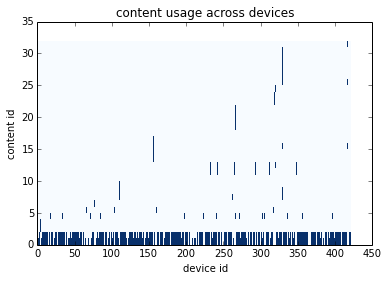

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pylab as pl
plt.figure()
rows = dids
columns = cid_used

fig, ax = plt.subplots()
heatmap = ax.pcolor(content_dev_usage.transpose(), cmap=plt.cm.Blues)
plt.xlabel('device id')
plt.ylabel('content id')
plt.title('content usage across devices')
plt.show()
plt.close()

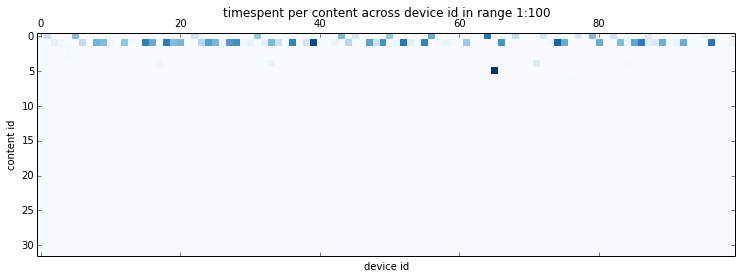

In [9]:
#plot timespent on content across devices
plt.figure()
rows = dids
columns = cid_used
plt.matshow(content_dev_timespent[0:100][:].transpose(),cmap=plt.cm.Blues)
plt.xlabel('device id')
plt.ylabel('content id')
plt.title('timespent per content across device id in range 1:100',)
plt.show()
plt.close()

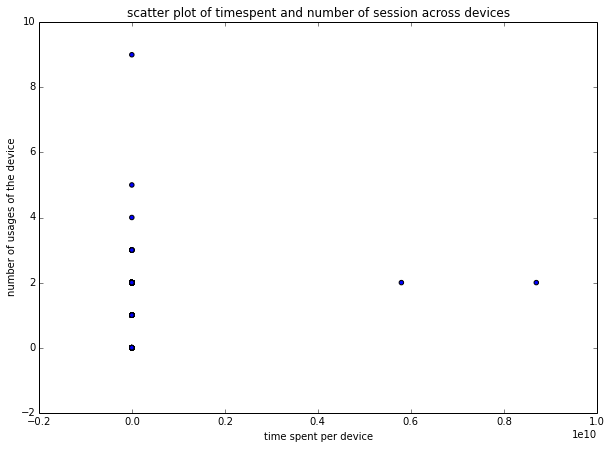

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(timePerDid,sessionPerDid)
plt.xlabel('time spent per device')
plt.ylabel('number of usages of the device')
plt.title('scatter plot of timespent and number of session across devices')
plt.show()
plt.close()

In [ ]:
#get content list from production 

#url = "http://lp-sandbox.ekstep.org:8080/taxonomy-service/v2/analytics/content/list"
url="http://52.77.241.169:8080/taxonomy-service/v2/content/list"
resp2 = requests.post(url)

In [ ]:
#contents=np.zeros(len(resp2['result']['contents']),dtype=np.int)
cids=["" for x in range(len(resp2['result']['contents']))]
dids=["" for x in range(len(resp))]
content_dev_usage=np.zeros((len(resp),len(resp2['result']['contents'])))
content_dev_timespent=np.zeros((len(resp),len(resp2['result']['contents'])))
p=[]
resp[1]['timespent']
for i in range(0,len(resp2['result']['contents'])):
    cids[i]=resp2['result']['contents'][i]['identifier']
    for num_did in range(1,len(resp)):
        if (resp[num_did]['content']!=None):
            if any(str(resp2['result']['contents'][i]['identifier']) in k for k in resp[num_did]['content']):
                content_dev_usage[num_did][i]=content_dev_usage[num_did][i]+1
                timeoncid=(resp[num_did]['timespent']*resp[num_did]['content'].count(resp2['result']['contents'][i]['identifier']))
                content_dev_timespent[num_did][i]=content_dev_timespent[num_did][i]+timeoncid
for num_did in range(1,len(resp)):    
    dids[num_did]=resp[num_did]['did']      
